# NL COVID 19 data exploration

- data from https://data.rivm.nl/covid-19/
- taken 2021-06-26

## Notes

- Given that daily reported numbers are in small quantities
(i.e. <100), changes represented in % changes
can be highly sensitive.
E.g. Changing from 1 to 5 is a 500% change.
- But % change is the only way to
compare change in qty across different slices
of data.
- So take those figures with a pinch of salt.
- That being said, we are looking for anomalies,
so a sufficiently large % change would signal
an abnormally large change.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import typing

plt.rcParams["figure.figsize"] = (20,15)
_FONTSIZE=20

# Initial data management
_DATADIR="_data"
_DATA_CUMUL="COVID-19_aantallen_gemeente_cumulatief-2021-06-26.csv"
cumul = pd.read_csv(os.path.join(_DATADIR, _DATA_CUMUL), delimiter=";")
cumul["Date_of_report"] = pd.to_datetime(cumul["Date_of_report"]) # set dtype of "Date_of_report" to pd.DatetimeTZDtype
cumul["Date_of_report"] = cumul["Date_of_report"].dt.normalize() # get date portion of datetime only
cumul.sort_values(by="Date_of_report",ascending=True,inplace=True)

 # Get only cases from Amsterdam:
cumul_ams = cumul[cumul["Municipality_name"].isin(["Amsterdam"])]

# compare day on day increments/deltas
def get_daily_delta(df: pd.DataFrame, col: str) -> typing.List[int]:
    """
    Returns list containing daily reported cases
    """
    daily_delta_column = []
    reported = df[col]
    for i in range(0,len(reported)):
        if i == 0:
            daily_delta_column.append(0)
            continue # skip this index
        daily_delta_column.append(
            reported.iloc[i]-reported.iloc[i-1]
        )

    return daily_delta_column

cumul_ams.insert(len(cumul_ams.columns), "Day",cumul_ams["Date_of_report"].dt.day_name()) # create new column for day of week
cumul_ams["Day"].astype("str")
cumul_ams.insert(len(cumul_ams.columns), "Week", cumul_ams["Date_of_report"].dt.isocalendar().week) # create new column for week number
cumul_ams.insert(len(cumul_ams.columns), "Year", cumul_ams["Date_of_report"].dt.isocalendar().year) # create new column for week number
cumul_ams.insert(len(cumul_ams.columns),"Daily_delta",get_daily_delta(cumul_ams, "Total_reported")) # add daily delta of total reported to df
cumul_ams.insert(len(cumul_ams.columns),"Deceased_delta",get_daily_delta(cumul_ams, "Deceased")) # add daily delta of total deceased to df
cumul_ams.insert(len(cumul_ams.columns),"Hospital_delta",get_daily_delta(cumul_ams, "Hospital_admission")) # add daily delta of total hospitalized to df

/Users/zeddee/src/nl-covid19-eda/.direnv/python-3.9.2/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Get only the data we want from dataframe

In [2]:
# create working df with: date, cumulative day of week, week number, reports
cumuldf = cumul_ams[
    ["Date_of_report","Day","Week","Year","Daily_delta", "Total_reported", "Deceased", "Deceased_delta", "Hospital_admission", "Hospital_delta"]
]
cumuldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471 entries, 109 to 172086
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date_of_report      471 non-null    datetime64[ns]
 1   Day                 471 non-null    object        
 2   Week                471 non-null    UInt32        
 3   Year                471 non-null    UInt32        
 4   Daily_delta         471 non-null    int64         
 5   Total_reported      471 non-null    int64         
 6   Deceased            471 non-null    int64         
 7   Deceased_delta      471 non-null    int64         
 8   Hospital_admission  471 non-null    int64         
 9   Hospital_delta      471 non-null    int64         
dtypes: UInt32(2), datetime64[ns](1), int64(6), object(1)
memory usage: 37.7+ KB


### Data from last 10 days

In [3]:
cumuldf.tail(10)

,Date_of_report,Day,Week,Year,Daily_delta,Total_reported,Deceased,Deceased_delta,Hospital_admission,Hospital_delta
168810,2021-06-17,Thursday,24,2021,58,88666,813,1,1952,1
169174,2021-06-18,Friday,24,2021,60,88726,813,0,1953,1
169538,2021-06-19,Saturday,24,2021,49,88775,814,1,1955,2
169902,2021-06-20,Sunday,24,2021,45,88820,814,0,1957,2
170266,2021-06-21,Monday,25,2021,33,88853,814,0,1959,2
170630,2021-06-22,Tuesday,25,2021,51,88904,814,0,1959,0
170994,2021-06-23,Wednesday,25,2021,30,88934,814,0,1959,0
171358,2021-06-24,Thursday,25,2021,45,88979,814,0,1959,0
171722,2021-06-25,Friday,25,2021,45,89024,814,0,1959,0
172086,2021-06-26,Saturday,25,2021,33,89057,814,0,1959,0


### Top 10 days (reported cases)

In [4]:
sorted_df = cumuldf[["Date_of_report","Week","Daily_delta","Total_reported","Hospital_delta"]].sort_values(by="Daily_delta",ascending=False)
sorted_df.head(10)

,Date_of_report,Week,Daily_delta,Total_reported,Hospital_delta
83051,2020-10-25,43,831,27273,8
81950,2020-10-22,43,813,25191,14
81583,2020-10-21,43,751,24378,7
82317,2020-10-23,43,745,25936,14
78647,2020-10-13,42,734,19163,16
80482,2020-10-18,42,726,22398,7
81216,2020-10-20,43,696,23627,3
80115,2020-10-17,42,687,21672,19
83785,2020-10-27,44,686,28485,6
79748,2020-10-16,42,682,20985,7


In [5]:
def get_week_start_end(df:pd.DataFrame, week_number:int)->typing.Tuple[str,str]:
    """
    Returns a tuple of (week_start, week_end),
    that are two strings:
    - week_start is the start date of a week (i.e. dd/mm on that monday)
    - week_end is the end date of a week (i.e. dd/mm on that sunday)
    """
    df_week = df["Week"]
    # this_week = df[df_week == df_week.max()-week_number]
    this_week = df[df_week == week_number]
    week_start = this_week.iloc[0]["Date_of_report"]
    week_start_d_m = f"{week_start.day}/{week_start.month}"
    week_end = this_week.iloc[-1]["Date_of_report"]
    week_end_d_m = f"{week_end.day}/{week_end.month}"
    return week_start_d_m, week_end_d_m


def plot_daily_delta_for_last_n_weeks(df:pd.DataFrame, n:int=3, year:int=2021):
    """
    Plots n number of weeks
    worth of daily deltas in one line chart
    """
    plt.grid(True)
    plt.xticks(rotation="vertical", fontsize=_FONTSIZE)
    plt.xlabel("Day of week", fontsize=_FONTSIZE)
    plt.yticks(np.arange(0, df["Daily_delta"].max(), step=5), fontsize=_FONTSIZE)
    plt.ylabel("Daily change", fontsize=_FONTSIZE)

    for week in range(0,n):

        df = df[df["Year"] == year]
        today = df["Date_of_report"].max()
        this_week_number = pd.Timestamp(today).week - week
        # we previously tried to get the week number by getting
        # the max value of df["Week"] (the week column),
        # but that breaks when we move from one year to the next
        # now, get week from the latest report.
        this_week = df[df["Week"] == this_week_number]
        last_week = df[df["Week"] == this_week_number-1]

        x_range = ["(Sunday before)"]+this_week["Day"].to_list()
        including_last_sunday = [last_week["Daily_delta"].to_list()[-1]]+this_week["Daily_delta"].to_list()
        week_start_d_m, week_end_d_m = get_week_start_end(df,this_week_number)

        plt.plot(x_range,including_last_sunday,label=f"{week_start_d_m} – {week_end_d_m}")
    plt.legend(fontsize=_FONTSIZE)

### Plot daily reported cases, by week

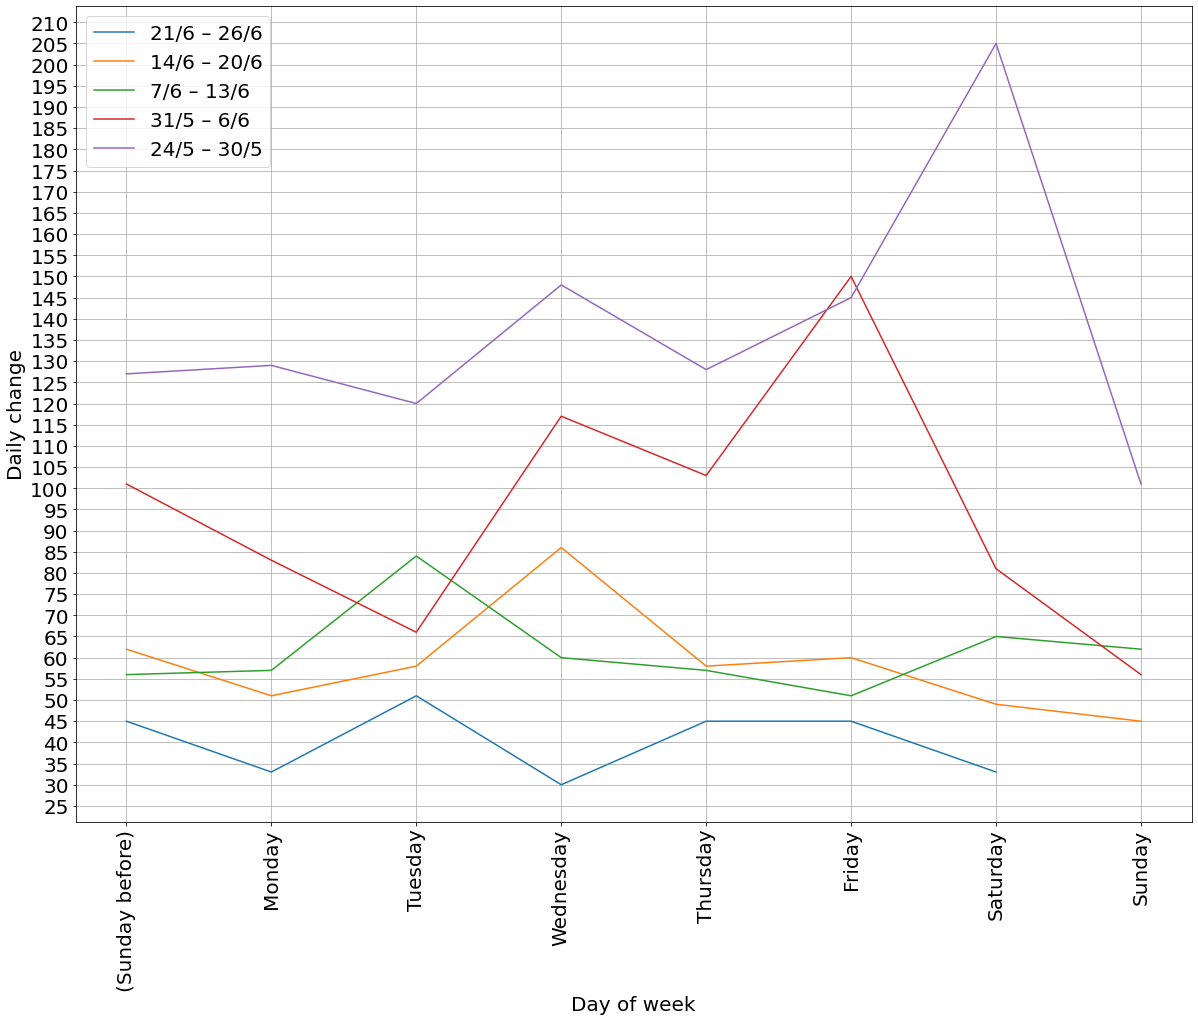

,Date_of_report,Week,Daily_delta,Total_reported
169902,2021-06-20,24,45,88820
170266,2021-06-21,25,33,88853
170630,2021-06-22,25,51,88904
170994,2021-06-23,25,30,88934
171358,2021-06-24,25,45,88979
171722,2021-06-25,25,45,89024
172086,2021-06-26,25,33,89057


In [6]:
plot_daily_delta_for_last_n_weeks(cumuldf, n=5)
plt.show()

cumuldf[["Date_of_report","Week","Daily_delta","Total_reported"]].tail(7)

In [7]:
def plot_weekly_delta_for_last_n_weeks(df:pd.DataFrame, n:int) -> typing.Dict[str,int]:
    """
    Returns a dict containing weekly delta for the last n weeks,
    like: {"Week n": int,"Week n-1": int, ...}
    """

    weekly_delta = {}
    for week in range(0,n):
        this_week = pd.Timestamp(df["Date_of_report"].max()).week
        if this_week < week:
            print(f"Week no. {this_week - week} does not exist.")
            continue

        this_week_num = this_week - week
        week_delta = df[df["Week"] == this_week_num]["Daily_delta"].sum()

        if this_week_num == 0:
            weekly_delta[f"Week {this_week_num}"] = 0
            continue
        else:
            weekly_delta[f"Week {this_week_num}"] = week_delta
            continue
    return weekly_delta



### Plot week-on-week reported cases

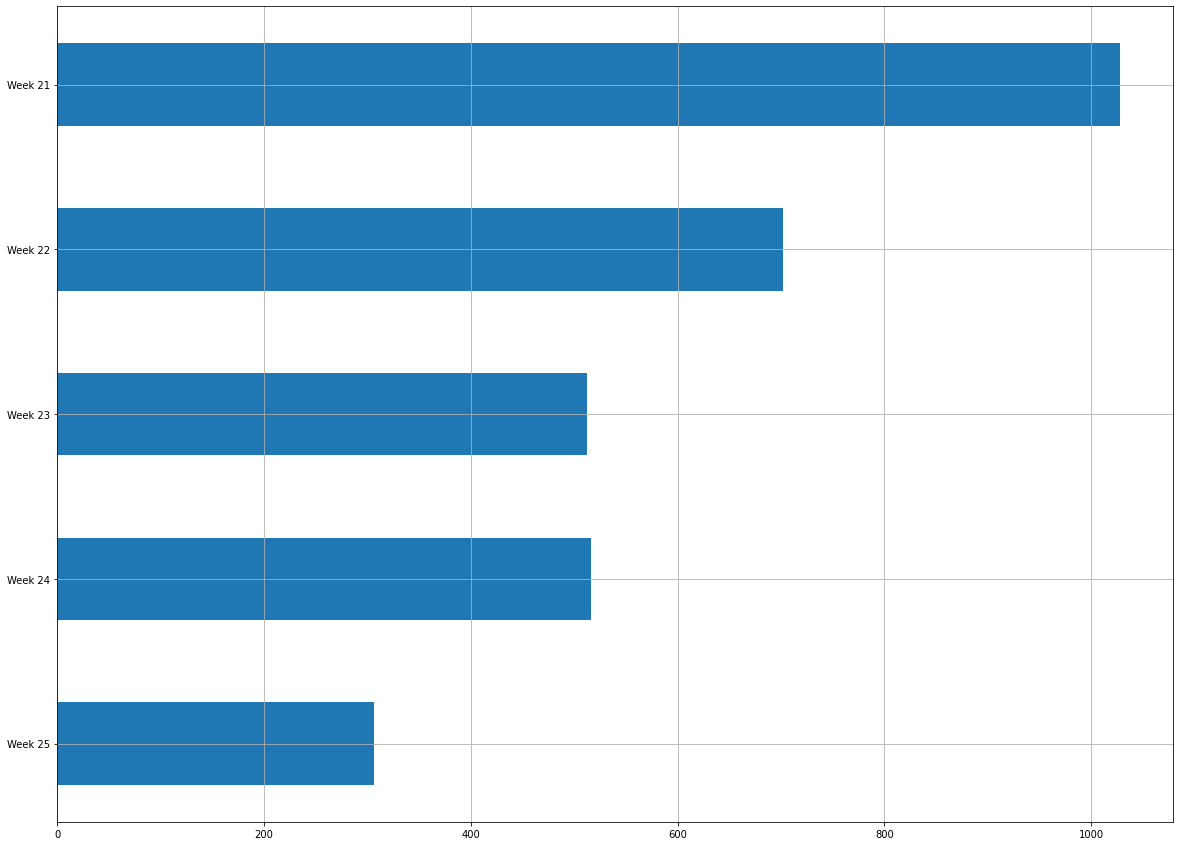

{'Week 21': 1028,
 'Week 22': 702,
 'Week 23': 512,
 'Week 24': 516,
 'Week 25': 306}


In [8]:
weekly_delta = plot_weekly_delta_for_last_n_weeks(cumuldf, 5)
plt.grid(True)
plt.barh(
    list(weekly_delta.keys()),
    width=np.array(list(weekly_delta.values())),
    height=0.5
)
plt.show()
pprint(weekly_delta)

In [9]:
# Helper function to plot last n days cumulative reported cases

def plot_cumul_reported_last_n_days(df:pd.DataFrame,n:int=3, col:str="Total_reported") -> None:
    plot_this = df.tail(n)
    plt.grid(True)
    plt.xticks(rotation="vertical", fontsize=_FONTSIZE)
    plt.yticks(plot_this[col], fontsize=_FONTSIZE)
    plt.plot_date(
        plot_this["Date_of_report"].loc[-n:,],
        plot_this[col],
        xdate=True
    )
    plt.show()
    pprint(df[["Date_of_report", col]].tail(n))

### Cumulative reported cases for the last 30 days

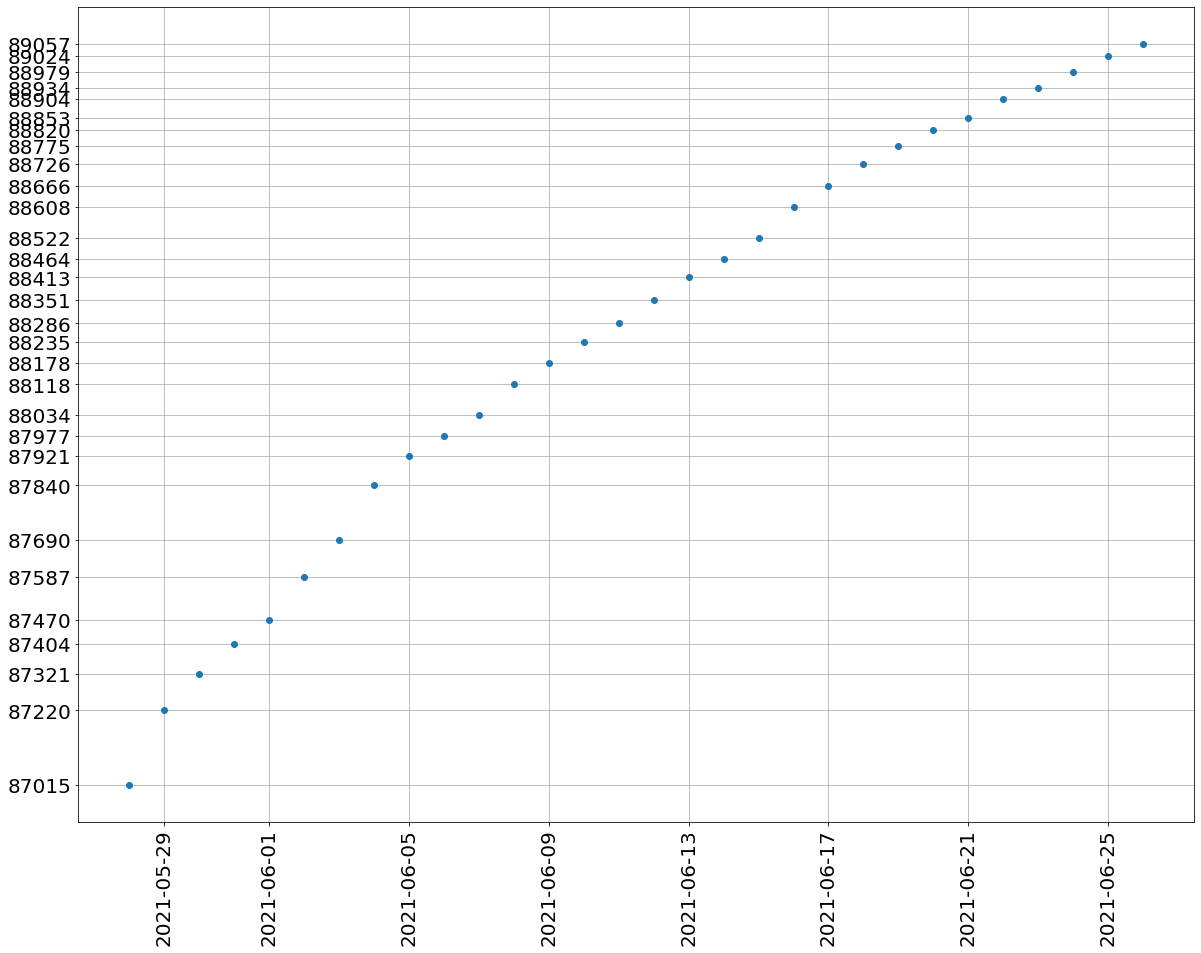

       Date_of_report  Total_reported
161530     2021-05-28           87015
161894     2021-05-29           87220
162258     2021-05-30           87321
162622     2021-05-31           87404
162986     2021-06-01           87470
163350     2021-06-02           87587
163714     2021-06-03           87690
164078     2021-06-04           87840
164442     2021-06-05           87921
164806     2021-06-06           87977
165170     2021-06-07           88034
165534     2021-06-08           88118
165898     2021-06-09           88178
166262     2021-06-10           88235
166626     2021-06-11           88286
166990     2021-06-12           88351
167354     2021-06-13           88413
167718     2021-06-14           88464
168082     2021-06-15           88522
168446     2021-06-16           88608
168810     2021-06-17           88666
169174     2021-06-18           88726
169538     2021-06-19           88775
169902     2021-06-20           88820
170266     2021-06-21           88853
170630     2

In [10]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Total_reported")

### Cumulative reported cases since beginning

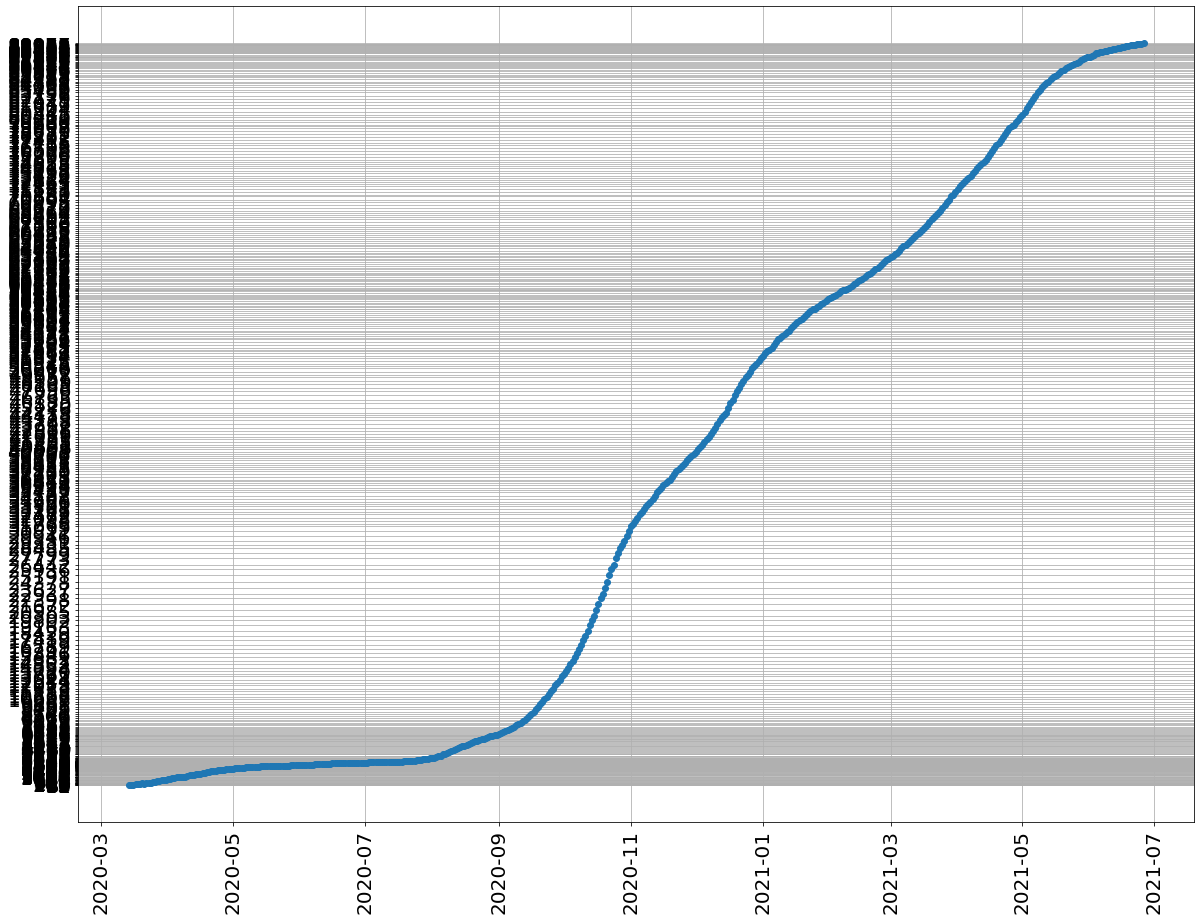

       Date_of_report  Total_reported
476        2020-03-14              31
843        2020-03-15              31
1210       2020-03-16              39
1577       2020-03-17              56
1944       2020-03-18              61
...               ...             ...
170630     2021-06-22           88904
170994     2021-06-23           88934
171358     2021-06-24           88979
171722     2021-06-25           89024
172086     2021-06-26           89057

[470 rows x 2 columns]


In [11]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Total_reported")

### Cumulative hospitalizations for last 30 days

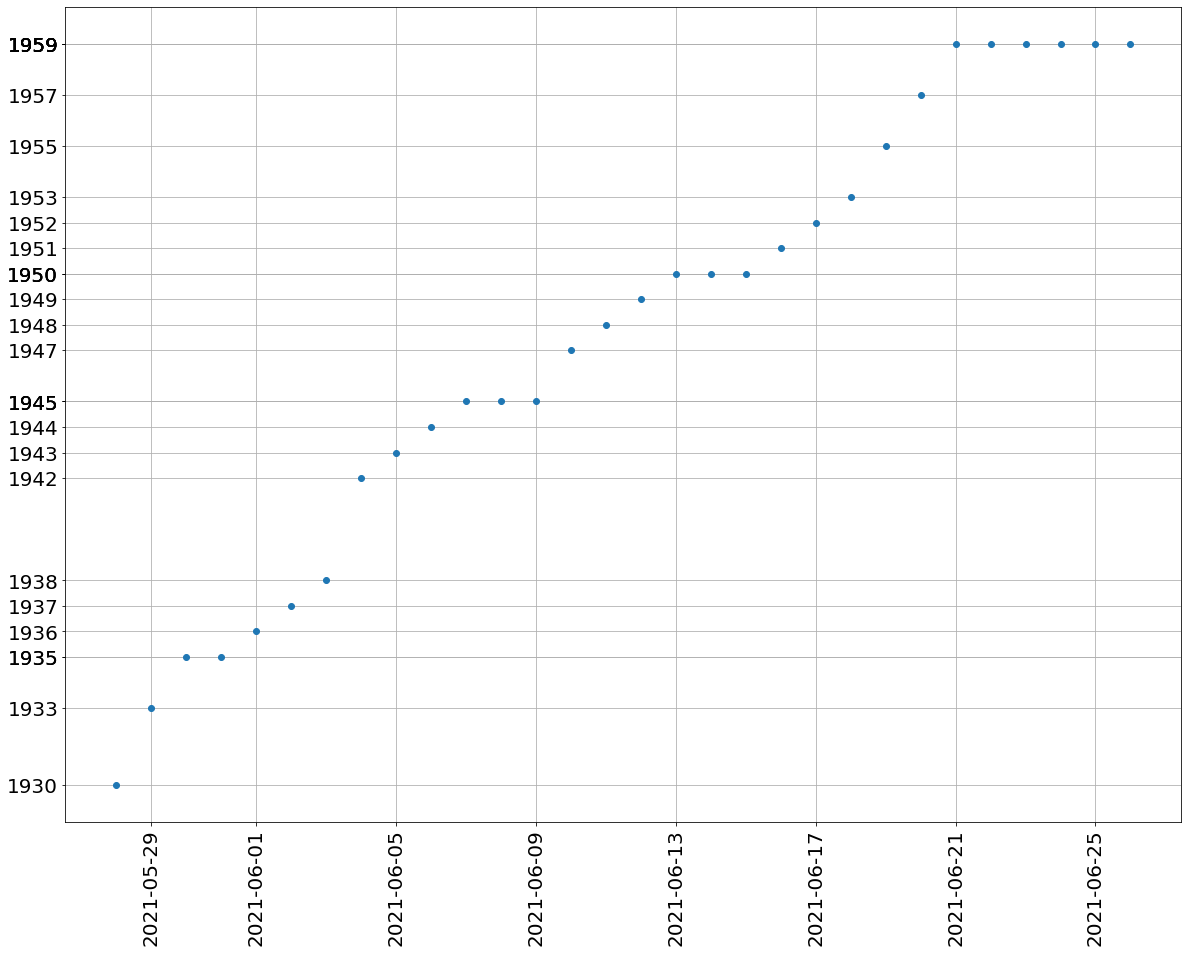

       Date_of_report  Hospital_admission
161530     2021-05-28                1930
161894     2021-05-29                1933
162258     2021-05-30                1935
162622     2021-05-31                1935
162986     2021-06-01                1936
163350     2021-06-02                1937
163714     2021-06-03                1938
164078     2021-06-04                1942
164442     2021-06-05                1943
164806     2021-06-06                1944
165170     2021-06-07                1945
165534     2021-06-08                1945
165898     2021-06-09                1945
166262     2021-06-10                1947
166626     2021-06-11                1948
166990     2021-06-12                1949
167354     2021-06-13                1950
167718     2021-06-14                1950
168082     2021-06-15                1950
168446     2021-06-16                1951
168810     2021-06-17                1952
169174     2021-06-18                1953
169538     2021-06-19             

In [12]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Hospital_admission")

### Cumulative hospitalizations since beginning

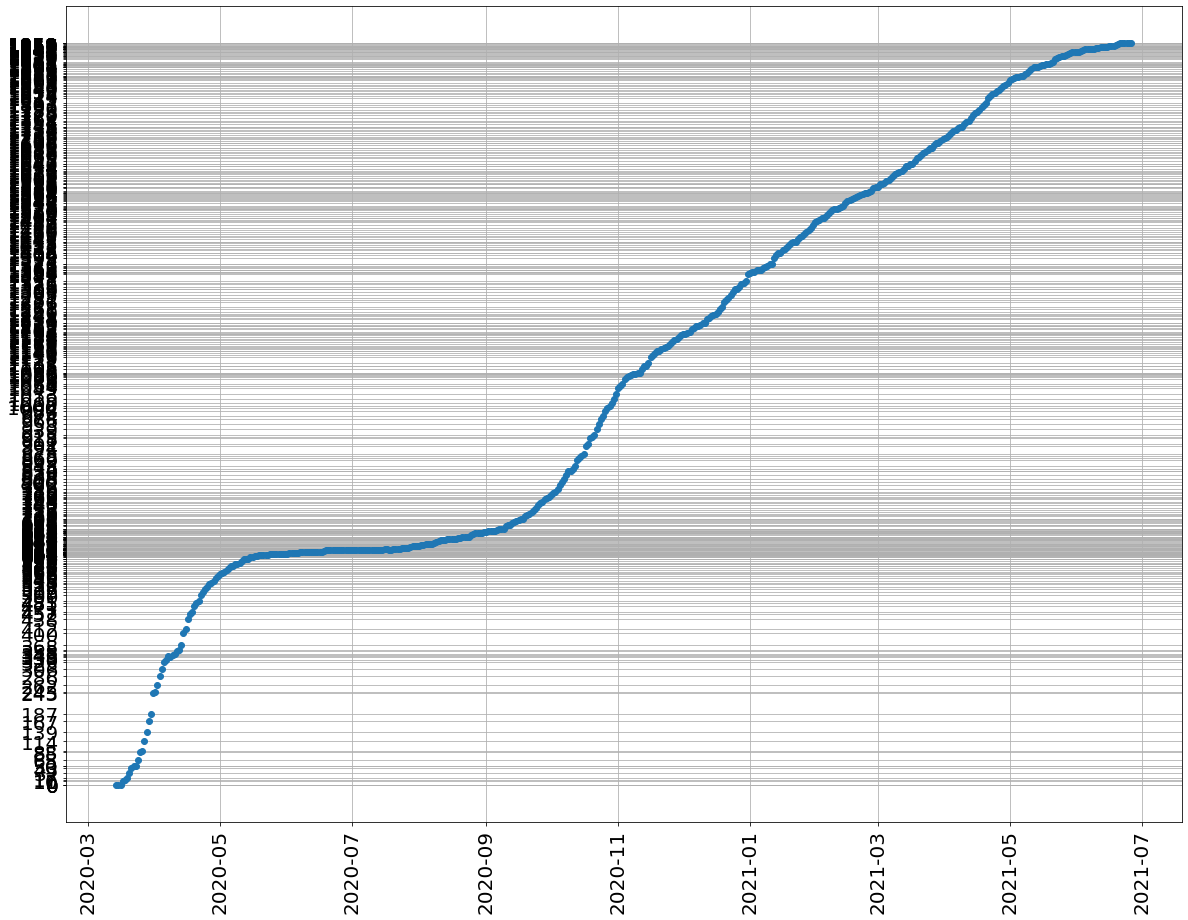

       Date_of_report  Hospital_admission
476        2020-03-14                   0
843        2020-03-15                   0
1210       2020-03-16                   0
1577       2020-03-17                  10
1944       2020-03-18                  11
...               ...                 ...
170630     2021-06-22                1959
170994     2021-06-23                1959
171358     2021-06-24                1959
171722     2021-06-25                1959
172086     2021-06-26                1959

[470 rows x 2 columns]


In [13]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Hospital_admission")

### Cumulative deaths since beginning

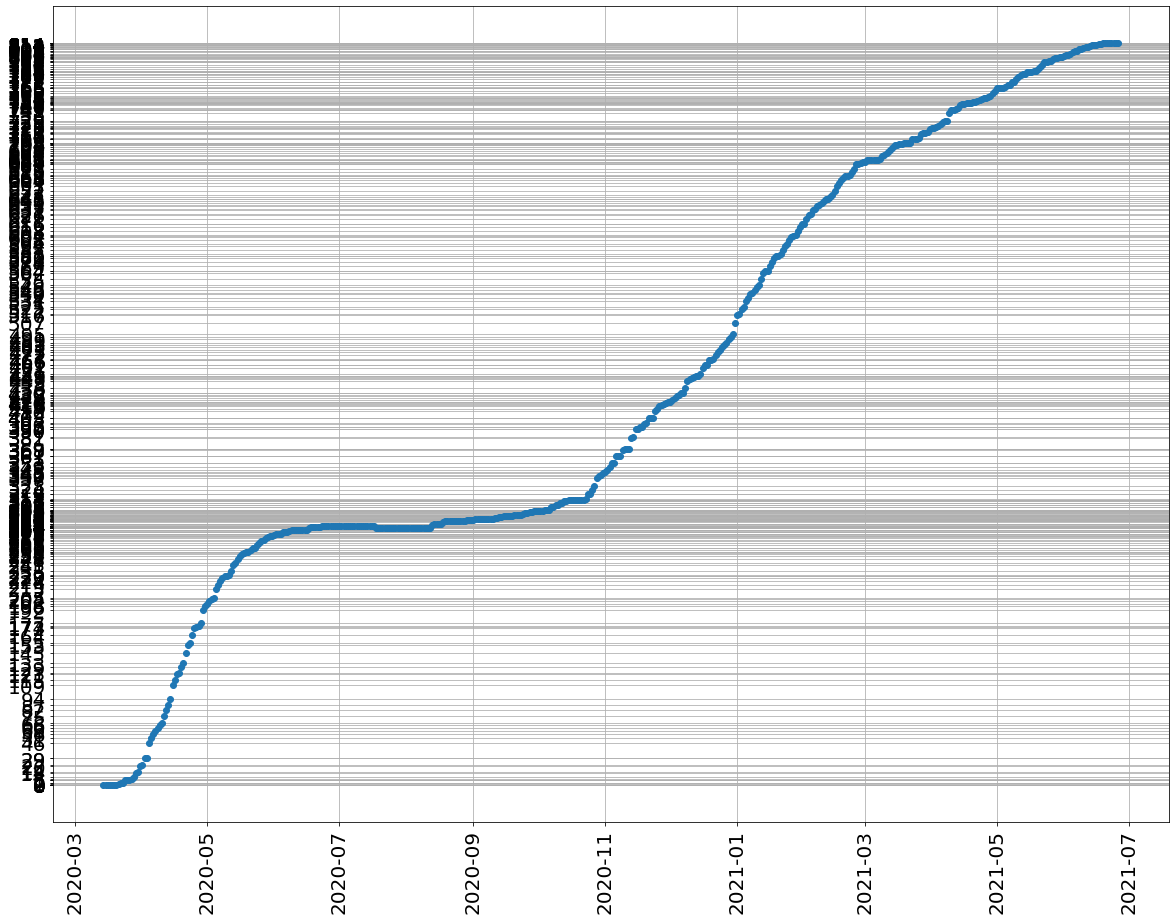

       Date_of_report  Deceased
476        2020-03-14         0
843        2020-03-15         0
1210       2020-03-16         0
1577       2020-03-17         0
1944       2020-03-18         0
...               ...       ...
170630     2021-06-22       814
170994     2021-06-23       814
171358     2021-06-24       814
171722     2021-06-25       814
172086     2021-06-26       814

[470 rows x 2 columns]


In [14]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Deceased")